# The twitter-momentum strategy of Sparky's Stone Securities

- The high level idea is to evaluate the sentiment from tweets containing S&P500 
tickers mentions (i.e. $AAPL) from different accounts (influencers or accounts specialized in finance).

- The sentiment score will be summed monthly, so each month we will have N stocks, with a sum of sentiment analysis. The sum of sentiment scores will be converted to weights in a portfolio.

- We will evaluate tweets for 1 month, form a portfolio, and invest on it in the following month. We will repeat the process over a year and compare our performance with market benchmarks.

- **CAN WE BEAT THE MARKET WITH THIS SIMPLE STRATEGY?**



#### Importing libraries

In [ ]:
import os
import tweepy as tw
import pandas as pd
import re
import string
string.punctuation
from nltk.corpus import stopwords
import regex
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yf
import numpy as np
import seaborn as sns
import datetime
import statsmodels.api as sm

### First, we need to connect to Twitter API

In [ ]:
#@title Loging into Vitor's account (hidden API key)
consumer_key= 'sHkRC5EGTwQnw1HBuLL859fH4'
consumer_secret= 'zLbjK5vP0yEUF9AMiS6V1NJiO39QSiK6wDFmKPEyZttJnakTgS'
access_token= '1206665201891893248-rHLkV5Pb42BCoz6oWcI0FWOQ8qHvOM'
access_token_secret= 'RjJ38zELECStbuosM2UBjiCN1r34j5ssEdw9EL8ViHdvk'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

### Second, we download selected accounts' tweets, and save it all into one file, to avoid doing it again all times (it takes some time)

In [ ]:
#Twitter accounts to look for
users = ["@WSJbusiness",  "@SeekingAlpha", "@YahooFinance", "@ftfinancenews", "@NYSE", "@CNNBusiness","@ReutersBiz", "@breakingviews", "@Forbes","@CNBCFastMoney",
         "@MadMoneyOnCNBC", "@SquawkStreet", "@MorningstarInc", "@markets", "@TheStreet", "@Stocktwits", "@IBDinvestors", "@DanZanger", "@traderstewie",
         "@dKellerCMT", "@allstarcharts", "@KimbleCharting", "@hmeisler", "@SJosephBurns",  "@steve_hanke", "@MarketWatch", "@bespokeinvest", "@CNBC",
         "@SquawkCNBC", "@barronsonline"]

#Downloading tweets from tt API
all_tweets = pd.DataFrame(columns=['user', "location", "text", "create_at"])
start_date = datetime.datetime(2020,4, 1, 00, 00, 00)
for i in users:
  try:
  # Collect tweets
    tweets = tw.Cursor(api.user_timeline,
                        screen_name=i,since=start_date).items(3000)

    twts_we_want = [[tweet.user.screen_name, tweet.user.location, tweet.text, tweet.created_at] for tweet in tweets]
    inter = pd.DataFrame(data=twts_we_want, 
                      columns=['user', "location", "text", "create_at"])

    #Pandas df of tweets
    all_tweets = all_tweets.append(inter)
    print(i)
  except:
    pass
all_tweets.to_excel(r'/content/sample_data/tt.xlsx')

@steve_hanke
@MarketWatch
@bespokeinvest
@IBDinvestors
@CNBC


In [ ]:
#Read File
all_tweets = pd.read_excel(r'/content/all_tweets (1).xlsx')

This is the number of users that we got. However, it is still considering all tickers (not only S&P500)

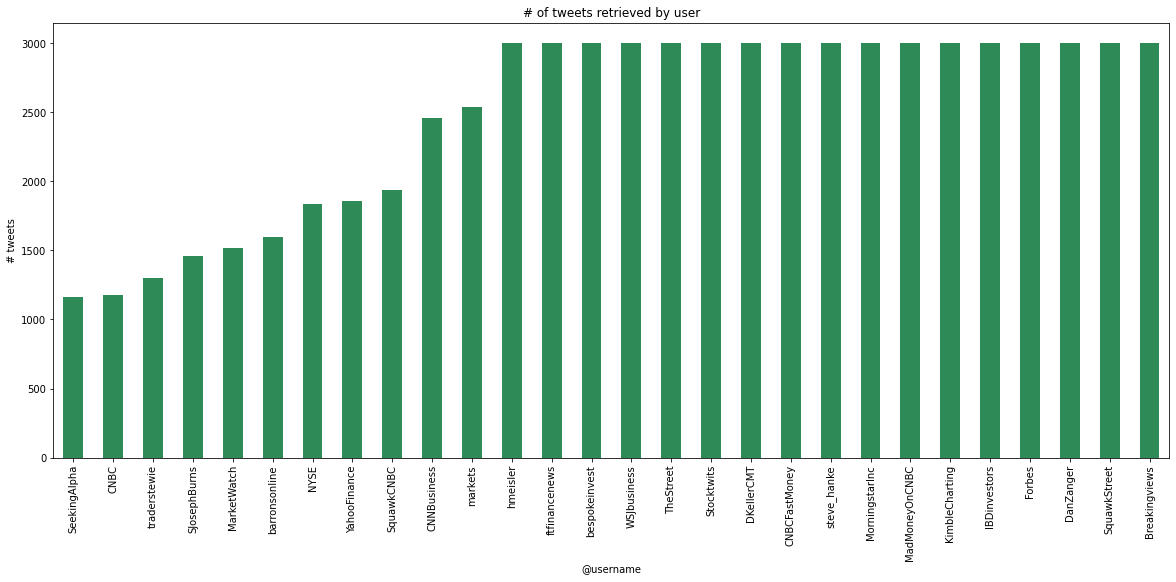

In [74]:
#@title Number of tweets per user
#number of tweets per user
fig,ax = plt.subplots(figsize=(20,8))
ax = all_tweets.groupby('user').count()['text'].sort_values().plot(kind='bar', color = "seagreen")
ax.set_xlabel('@username')
ax.set_ylabel('# tweets')
ax.set_title("# of tweets retrieved by user");

Now we work a bit on the tweets, to extract the tickers, get the sentiment score and filter only S&P500 tickers.

(Nothing new, pretty much what we did on HW1)

In [62]:
#@title Cleaning
#Clean text from tweets
df = all_tweets

df['Timestamp'] = df['create_at']
df['Timestamp'] = df.Timestamp.astype('M8[ns]',).astype('O')
df['Date'] = df.Timestamp.apply(lambda x: x.strftime('%Y/%m/%d'))
df['Date']= pd.to_datetime(df['Date'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'],format='%I%M%S')
df['ID_date'] = df['Date'].dt.strftime('%Y-%m')
df['full_text'] = df['text'].astype(str)

#Get only a year back
df = df[df['Date'] >= '2020-04-01']
df = df.reset_index()

#Split words
text = [x.split(' ') for x in df.full_text]

#loop and remove links, mentions and #
prefixes = ('https', '#', '@','\n','\r')
remv_punc = str.maketrans('','',string.punctuation + '“' +"‘"+'”' + "'")
separator = ' '
replaces = ['‘',"\n","\r","’",'"','¡']

for n in range(len(text)):
  text[n] = [x for x in text[n] if not x.startswith(prefixes)]
  text[n] = separator.join(text[n]).lower()
  for i in replaces:
    text[n] = text[n].replace(i," ")
  text[n] = text[n].translate(remv_punc)
  text[n] = text[n].split(' ')
  text[n] = separator.join(text[n]).lower()

df['clean_text'] = text

#Take blank spaces out
df = df[df['clean_text'] != '']

#Drop duplicates
df = pd.DataFrame(df.drop_duplicates('clean_text'))

#Cleaning tickers
tickers_int = df.full_text.str.findall(r'([$][A-Za-z][\S]*)').explode().dropna().reset_index()#.drop_duplicates('index')
tickers_int['clean_ticker'] = tickers_int['full_text'].str[1:]

#Split words
text = [x.split(' ') for x in tickers_int.clean_ticker]

#loop and remove links, mentions and #
prefixes = ('https', '#', '@','\n','\r')
remv_punc = str.maketrans('','',string.punctuation + '“' +"‘"+'”' + "'" + "…")
separator = ' '
replaces = ['‘',"\n","\r","’",'"','¡']

for n in range(len(text)):
  text[n] = [x for x in text[n] if not x.startswith(prefixes)]
  text[n] = separator.join(text[n])
  for i in replaces:
    text[n] = text[n].replace(i," ")
  text[n] = text[n].translate(remv_punc)
  text[n] = text[n].split(' ')
  text[n] = separator.join(text[n])

tickers_int['clean_ticker'] = text

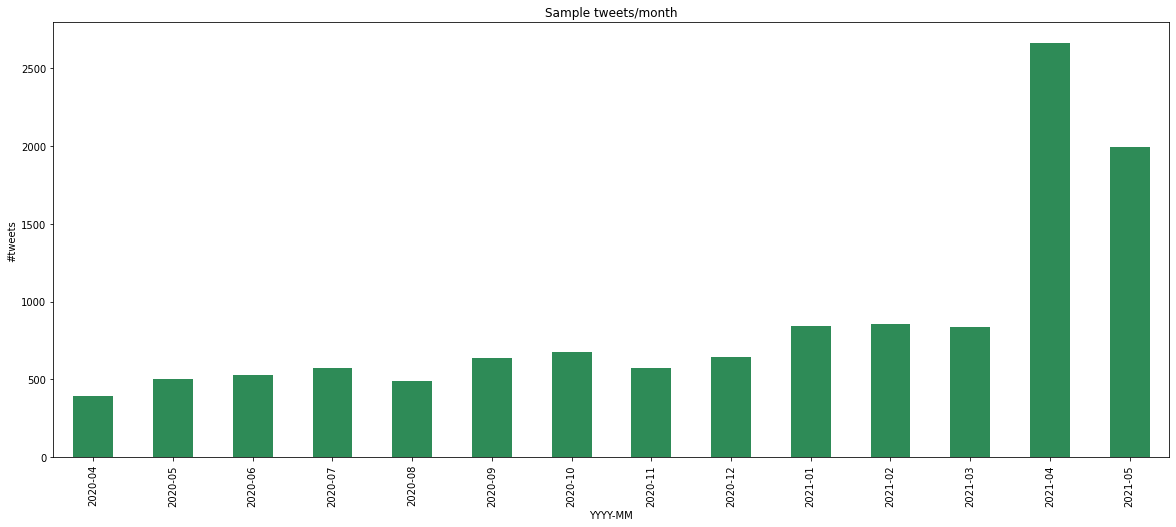

In [65]:
#@title Volume of tickers per month (all tickers)
#merge tickers in df and show volume 
df2 = df.merge(tickers_int, left_index=True, right_on='index', how='left')
df2 = df2[~df2['clean_ticker'].isna()]
fig,ax = plt.subplots(figsize=(20,8))
ax = df2.groupby(['ID_date']).count().text.plot(kind='bar', color = "seagreen")
ax.set_xlabel("YYYY-MM")
ax.set_ylabel("#tweets")
ax.set_title("Sample tweets/month");

### Then, we get the sentiment scores and sum it monthly

In [ ]:
#@title Getting sentiment scores
nltk.download('vader_lexicon');

#Get sentiment analysis
data_cleaned = df2[['user','location','text','Date','clean_text', 'ID_date','clean_ticker']]
sid = SentimentIntensityAnalyzer()
pol_scores = [sid.polarity_scores(x)['compound'] for x in data_cleaned['clean_text']]
data_cleaned['sentiment'] = pd.Series(pol_scores)

data_cleaned.shape

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(12216, 8)

In [ ]:
#@title Extracting the symbols from S&P500
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0].Symbol
tickers_vol = df.to_list()

#Getting only S&P500 tickers
data_cleaned = data_cleaned[data_cleaned['clean_ticker'].isin(tickers_vol)]
data_cleaned.shape

(4386, 8)

After selection only S&P500 tickers, we go from 12,216 tweets to 4,386. However, we wanted to avoid penny stocks, funds, cryptocurrencies etc.

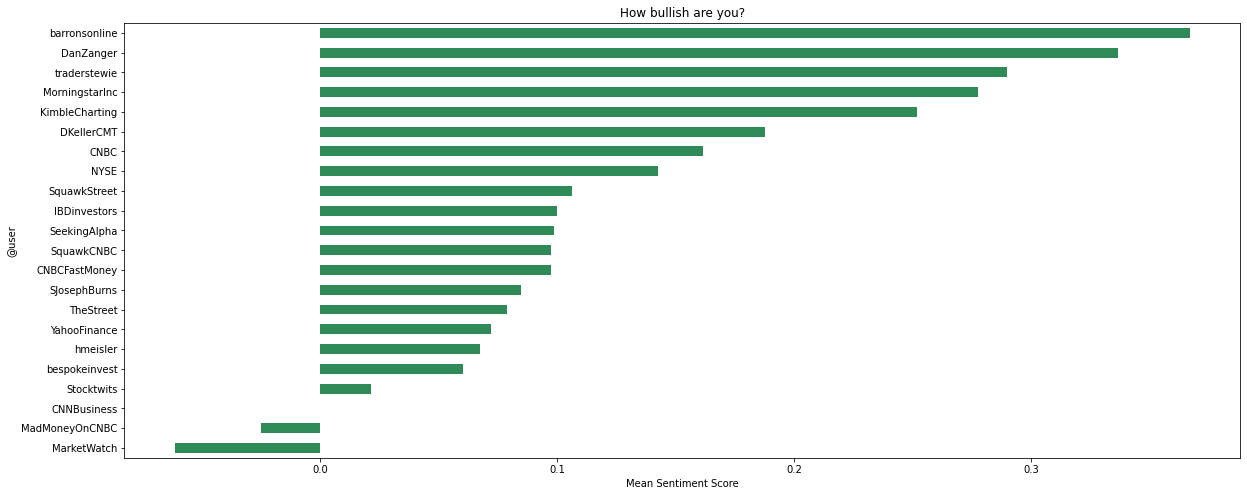

In [ ]:
#@title Average sentiment per user
#sentiment
fig,ax = plt.subplots(figsize=(20,8))
ax = data_cleaned.groupby('user').mean()['sentiment'].sort_values(ascending=True).plot(kind='barh', color='seagreen')
ax.set_ylabel("@user")
ax.set_xlabel("Mean Sentiment Score")
ax.set_title("How bullish are you?");

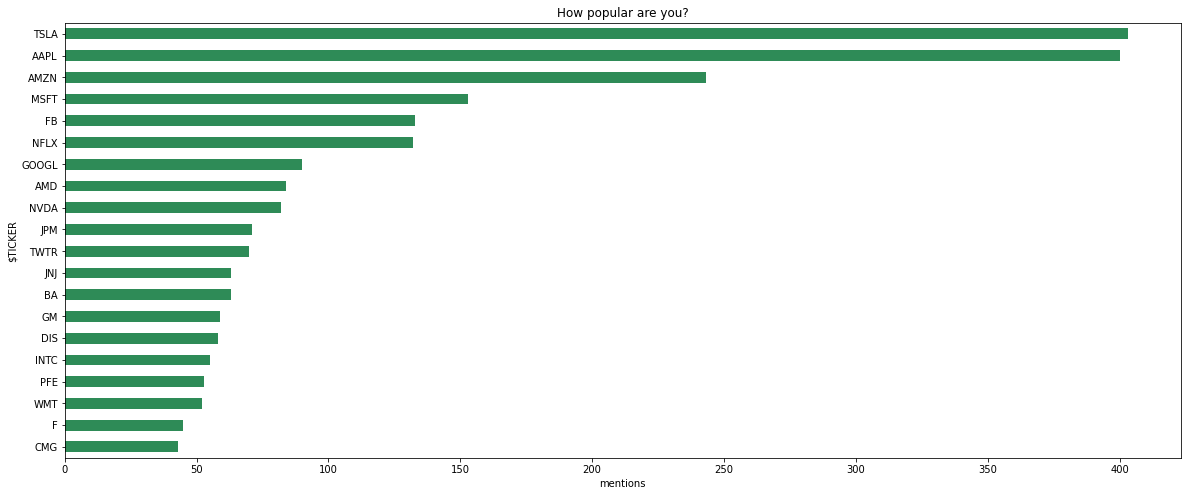

In [ ]:
#@title Number of tweets analysed by ticker

fig,ax = plt.subplots(figsize=(20,8))
ax = data_cleaned.groupby('clean_ticker').count()['sentiment'].sort_values(ascending=True).tail(20).plot(kind='barh', color = "seagreen")
ax.set_ylabel("$TICKER")
ax.set_xlabel("mentions")
ax.set_title("How popular are you?");

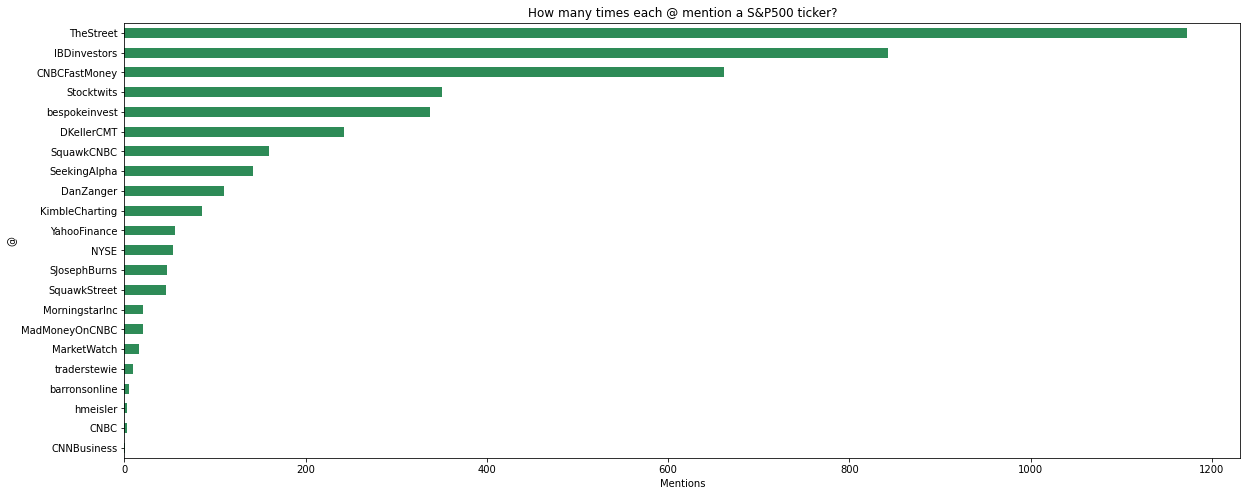

In [67]:
#@title S&P500 tickers mentions per user
fig,ax = plt.subplots(figsize=(20,8))
ax = data_cleaned.groupby(['user']).count().sort_values('clean_ticker').text.plot(kind='barh', color = "seagreen")
ax.set_ylabel("@")
ax.set_xlabel("Mentions")
ax.set_title("How many times each @ mention a S&P500 ticker?");

Then, this is what we have so far... a list of tickers, with the sum of sentiment scores in a month.

In [72]:
#@title Usntacking to see sum of sentiments per tickers and month
#usntacking to see sentiments and tickers
df_final0 = pd.DataFrame(columns=['sum_sentiment'])
df_final0['sum_sentiment'] = data_cleaned.groupby(['ID_date','clean_ticker']).sum()['sentiment']

df_final0[df_final0['sum_sentiment'] > 0].unstack().T.head()

ID_date                     2020-04  2020-05  ...  2021-04  2021-05
              clean_ticker                    ...                  
sum_sentiment ADBE           0.5495   0.3818  ...   1.0612      NaN
              AMD            0.9367   0.3108  ...   2.9087      NaN
              AMZN           1.5032      NaN  ...  12.3888   1.8696
              DPZ            0.8217   0.7430  ...   0.6124   0.4939
              DXCM           2.2483   1.8773  ...      NaN      NaN

[5 rows x 14 columns]

Cleaning tickers that are not supported in yfinance or are mispelled (we found tickers like "\$TLSA", "$AALP" for instance)

In [ ]:
#@title Checking if yahoo has all the tickers
#Getting rid of the tickers that are not found in yfinance
ticker_ok_name = df_final0[df_final0['sum_sentiment'] > 0].reset_index().clean_ticker.to_list()
xx = (df_final0[df_final0['sum_sentiment'] > 0].unstack(-1)).sum_sentiment.reset_index(0)
xx = xx.set_index('ID_date').T
xx = xx[xx.index.isin(ticker_ok_name)]
ticker_ok2 = yf.download(tickers=xx.index.to_list(), start='2020-04-01')['Volume']

[*********************100%***********************]  246 of 246 completed


### With the cleaned tickers, we calculate the weights, start and end dates for yfinance prices download

In [68]:
#@title Getting weitghts based on the sentiment analysis
#Getting weitghts based on the sentiment analysis
weights_final = (xx / xx.sum()).round(3)
weights_final.head(5)

ID_date,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05
clean_ticker,,,,,,,,,,,,,,
ADBE,0.033,0.015,NaN,NaN,0.037,0.014,0.002,NaN,NaN,NaN,NaN,NaN,0.007,NaN
AMD,0.056,0.012,0.035,0.037,0.075,NaN,0.063,NaN,0.038,0.049,NaN,NaN,0.020,NaN
AMZN,0.091,NaN,0.070,0.071,NaN,0.128,0.103,0.131,0.066,0.039,0.061,NaN,0.086,0.042
DPZ,0.050,0.029,NaN,0.022,NaN,0.017,NaN,NaN,NaN,NaN,NaN,NaN,0.004,0.011
DXCM,0.136,0.073,NaN,NaN,NaN,0.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#@title Looping through tickers to get tickers, weights, start and end dates.
#Getting tickers, weights, start and end dates
tickers=[]
weights=[]
start_dates =[]
end_dates=[]

for i in range(len(weights_final.T)):
  wint=weights_final.T.iloc[i].dropna().reset_index()
  wint = wint[wint.iloc[:,1]>0]
  ticker = wint['clean_ticker'].to_list()
  w = wint.iloc[:,1].to_list()
  tickers.append(ticker)
  weights.append(w)
  sdate = (pd.to_datetime(wint.iloc[:,1].name) + pd.DateOffset(months=1)- pd.to_timedelta(1, unit='d'))
  sdate = pd.to_datetime(sdate, format='%Y-%m-%d').strftime(format='%Y-%m-%d')
  start_dates.append(sdate)

  edate = (pd.to_datetime(wint.iloc[:,1].name) + pd.DateOffset(months=2) - pd.to_timedelta(1, unit='d'))
  edate = pd.to_datetime(edate, format='%Y-%m-%d').strftime(format='%Y-%m-%d')
  end_dates.append(edate)

Download all portfolios data, and merge into one dataframe. 
Obs.: we will see an error (some failed downloads). This is becuase the last porftolio (evalatuated in May), would start in June... so there is no data for those stocks and dates.

In [ ]:
#@title Downloding data from Yahoo Finance
#Getting S&P500 data
mkt0 = yf.download(tickers='^GSPC', start='2020-04-01')
mkt = pd.DataFrame(mkt0['Adj Close'])

#Getting NASDAQ (IXIC) and DJIA (DJI)
dji0 = yf.download(tickers='^DJI', start='2020-04-01')
nasdaq0 = yf.download(tickers='^IXIC', start='2020-04-01')

risk_free = 0.03

for i,f,s,e in zip(tickers,weights,start_dates,end_dates):
  try:
    dados_yahoo = yf.download(tickers=i, start=s, end=e)
    dados_yahoo.dropna(inplace=True)
    #analysis of data and parameters
    df = pd.DataFrame(dados_yahoo['Adj Close'])
    df = df.loc[s:e]
    df1 = df.pct_change() * f
    df1.iloc[0,:] = ((dados_yahoo['Close'].iloc[0] / dados_yahoo['Open'].iloc[0])-1) * f
    df1['portfolio'] = df1.sum(axis=1)
    mkt = mkt.merge(df1.portfolio, left_index=True, right_index=True,how='left')
  except:
    pass

### Step 6. Calculating the acumulated returns vs. benchmark

In [ ]:
#@title Generating portfolios
#Getting our portfolio
final_port = mkt.iloc[:,1:]
final_port = final_port.dropna(how='all', axis=0)
final_port.loc[final_port.index[0] - pd.to_timedelta(1, unit='d')] = 0
final_port = final_port.sort_index()
final_port = final_port.sum(axis=1)
final_port.iloc[0,:] = 0

#Getting benchmark (assuming holding it to the end)
benchmark = mkt.loc[final_port.index[0]:final_port.index[-1]].iloc[:,0]
benchmark = benchmark.pct_change()
benchmark.loc[benchmark.index[1]] = (mkt0['Open'][benchmark.index[1]]/ mkt0['Close'][benchmark.index[1]])-1
benchmark.loc[benchmark.index[0]] = 0
benchmark = benchmark.sort_index()

#Add NASDAQ and DJ
nasdaq = pd.DataFrame(nasdaq0['Adj Close'])
nasdaq = nasdaq.loc[final_port.index[0]:final_port.index[-1]].iloc[:,0]
nasdaq = nasdaq.pct_change()
nasdaq.loc[nasdaq.index[1]] = (nasdaq0['Open'][nasdaq.index[1]]/ nasdaq0['Close'][nasdaq.index[1]])-1
nasdaq.loc[nasdaq.index[0]] = 0
nasdaq = nasdaq.sort_index()

#Adding DJW
dji = pd.DataFrame(dji0['Adj Close'])
dji = dji.loc[final_port.index[0]:final_port.index[-1]].iloc[:,0]
dji = dji.pct_change()
dji.loc[dji.index[1]] = (dji0['Open'][dji.index[1]]/ dji0['Close'][dji.index[1]])-1
dji.loc[dji.index[0]] = 0
dji = dji.sort_index()

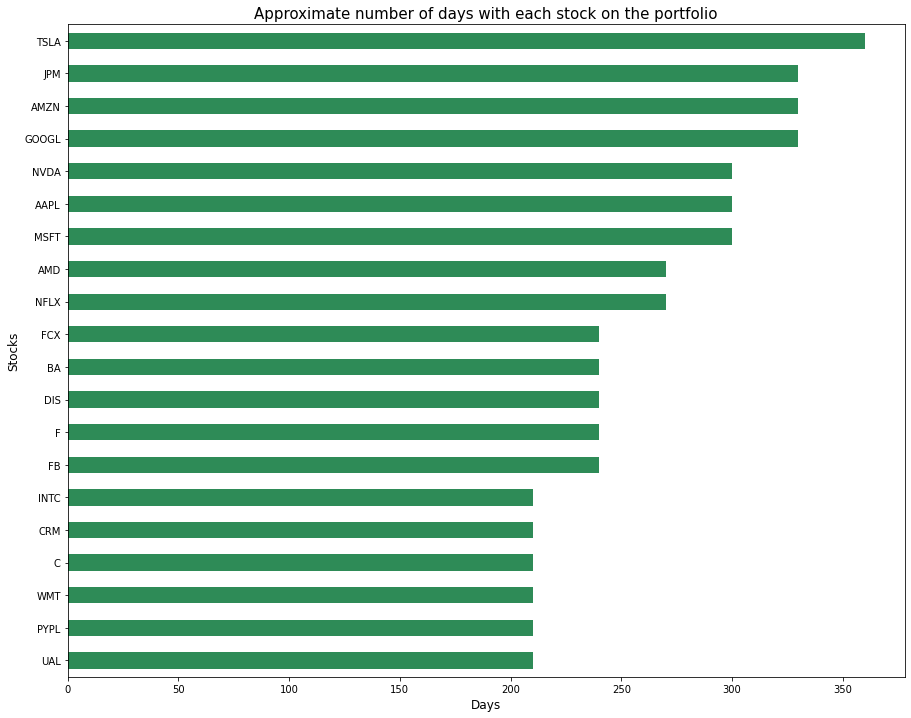

In [86]:
#@title Approximate number of days with each stock on the portfolio
tik=list(np.concatenate(tickers).flat)
treemap = (weights_final*0+30).T.sum().reset_index().sort_values(0,ascending=True)
treemap = treemap[treemap['clean_ticker'].isin(tik)].set_index('clean_ticker')

fig,ax = plt.subplots(figsize=(15,12))
treemap[-20:].plot(kind='barh', ax=ax, color='seagreen', legend=False)
# squarify.plot(sizes=treemap.iloc[:,1], label=treemap['clean_ticker'][:42],alpha=.4,)
ax.set_ylabel('Stocks', fontsize=12)
ax.set_xlabel('Days', fontsize=12)

plt.title('Approximate number of days with each stock on the portfolio', fontsize=15)
plt.show();

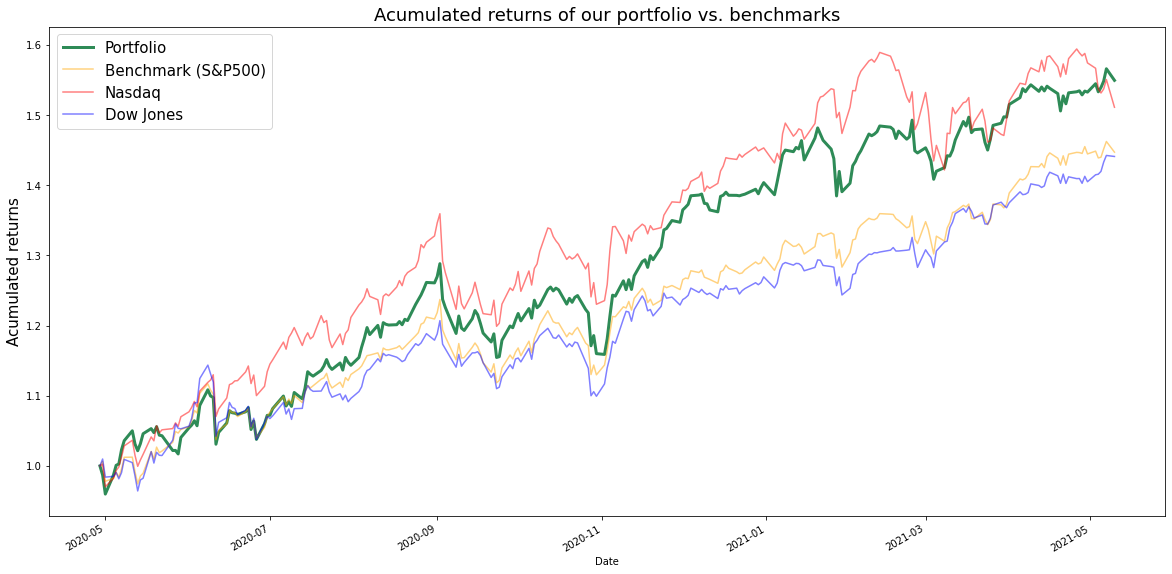

In [82]:
#@title Returns over time (if we have started with $1, how much would we have now?)
#plotting
fig,ax = plt.subplots(figsize=(20,10))
(final_port+1).cumprod().plot(color = "seagreen", linewidth=3)
(benchmark+1).cumprod().plot(c='orange', alpha=0.5)
(nasdaq+1).cumprod().plot(c='red', alpha=0.5)
(dji+1).cumprod().plot(c='blue', alpha=0.5)
ax.legend(['Portfolio', 'Benchmark (S&P500)','Nasdaq','Dow Jones'], fontsize=15)
ax.set_ylabel('Acumulated returns',fontsize=15)
plt.title('Acumulated returns of our portfolio vs. benchmarks',fontsize=18);

Wow! Let's look at our stats and daily returns distribution

In [85]:
#@title Statistics
stats = pd.DataFrame(final_port.describe(), columns=['Portfolio'])
stats['Benchmark (S&P500)'] = benchmark.describe()
stats['Nasdaq'] = nasdaq.describe()
stats['Dow Jones'] = dji.describe()
stats

,Portfolio,Benchmark (S&P500),Nasdaq,Dow Jones
count,260.000000,260.000000,260.000000,260.000000
mean,0.001764,0.001485,0.001690,0.001473
std,0.012510,0.011155,0.014141,0.011528
min,-0.060638,-0.058944,-0.052655,-0.068982
25%,-0.004721,-0.004407,-0.005474,-0.004229
50%,0.002559,0.002375,0.003761,0.001642
75%,0.009905,0.008336,0.010344,0.007631
max,0.028059,0.031501,0.038547,0.038503


Portfolio -->  Returns: 0.53 Risk: 0.2 Sharpe: 2.5
S&P500 -->  Returns: 0.43 Risk: 0.18 Sharpe: 2.25
Nasdaq -->  Returns: 0.49 Risk: 0.22 Sharpe: 2.05
DowJones -->  Returns: 0.42 Risk: 0.18 Sharpe: 2.15



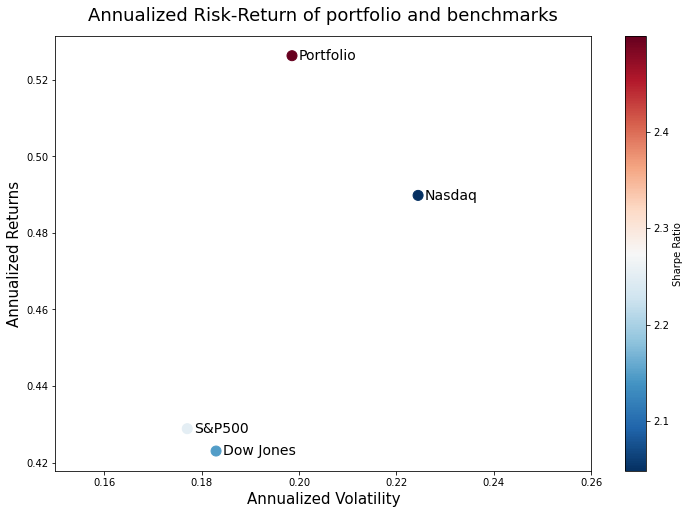

In [93]:
#@title Portfolio annualized performance
port_return = (final_port+1).cumprod()[-1]-1
port_annual_return = (1+port_return)**(251/len(final_port))-1
port_risk = final_port.iloc[1:].std()
port_annual_risk = port_risk * np.sqrt(251)
port_sharpe = (port_annual_return - risk_free) / port_annual_risk

#Market performance
mkt_return = (benchmark+1).cumprod()[-1]-1
mkt_annual_ret = (1+mkt_return)**(251/len(benchmark))-1
mkt_risk = benchmark.iloc[1:].std()
mkt_annual_risk = mkt_risk * np.sqrt(251)
mkt_sharpe = (mkt_annual_ret - risk_free) / mkt_annual_risk

#Nasdq performance
mkt_return2 = (nasdaq+1).cumprod()[-1]-1
mkt_annual_ret2 = (1+mkt_return2)**(251/len(nasdaq))-1
mkt_risk2 = nasdaq.iloc[1:].std()
mkt_annual_risk2 = mkt_risk2 * np.sqrt(251)
mkt_sharpe2 = (mkt_annual_ret2 - risk_free) / mkt_annual_risk2

#Dji performance
mkt_return3 = (dji+1).cumprod()[-1]-1
mkt_annual_ret3 = (1+mkt_return3)**(251/len(dji))-1
mkt_risk3 = dji.iloc[1:].std()
mkt_annual_risk3 = mkt_risk3 * np.sqrt(251)
mkt_sharpe3 = (mkt_annual_ret3 - risk_free) / mkt_annual_risk3

print('Portfolio --> ','Returns: '+str(port_annual_return.round(2)), 'Risk: '+str(port_annual_risk.round(2)),'Sharpe: '+str(port_sharpe.round(2)))
print('S&P500 --> ','Returns: '+str(mkt_annual_ret.round(2)), 'Risk: '+str(mkt_annual_risk.round(2)),'Sharpe: '+str(mkt_sharpe.round(2)))
print('Nasdaq --> ','Returns: '+str(mkt_annual_ret2.round(2)), 'Risk: '+str(mkt_annual_risk2.round(2)),'Sharpe: '+str(mkt_sharpe2.round(2)))
print('DowJones --> ','Returns: '+str(mkt_annual_ret3.round(2)), 'Risk: '+str(mkt_annual_risk3.round(2)),'Sharpe: '+str(mkt_sharpe3.round(2)))

print()

#@title Performances
performances = pd.DataFrame(columns=('Return', 'Risk','Sharpe'))
performances.loc['Portfolio'] = port_annual_return, port_annual_risk,port_sharpe
performances.loc['S&P500'] = mkt_annual_ret, mkt_annual_risk,mkt_sharpe
performances.loc['Nasdaq'] = mkt_annual_ret2, mkt_annual_risk2,mkt_sharpe2
performances.loc['Dow Jones'] = mkt_annual_ret3, mkt_annual_risk3,mkt_sharpe3

fig,ax= plt.subplots(figsize=(12,8))
x=performances['Return']
y=performances['Risk']
labels = performances.index
plt.scatter(y,x, s=100, c=performances['Sharpe'], cmap='RdBu_r')
for x_pos, y_pos, label in zip(y,x, labels):
    plt.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(7, 0),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='left',         # Horizontally aligned to the left
                va='center', fontsize=14)  
plt.colorbar(label='Sharpe Ratio')
plt.xlim(0.15,0.26)
plt.xlabel('Annualized Volatility', fontsize=15)
plt.ylabel('Annualized Returns', fontsize=15)
plt.title('Annualized Risk-Return of portfolio and benchmarks', fontsize=18, pad=15);


Greater returns, and lower risks! Thus, higher risk-return ratio (sharpe ratio)

(we considered a risk-free rate of 3%)

**Hey, looks like we BEAT the market!** 😎

Really? Let's not be fooled by returns only...

We will now evaluate our performance using a simple (yet useful) model, the CAPM pricing model.

The Capital Asset Pricing Model (CAPM) measures the expected amount of return gained per unit of systematic risk of an asset relative to the market portfolio. Jenson’s alpha (alpha) measures how the the portfolio or singular asset performs relative to the predicted CAPM value.

In a regression, the coeficient of the market is the Beta (systematic risk relative to market), and Alpha is the constant.

In [69]:
#@title CAPM Regression
#Simple OLS Linear regression
daily_rf = (1+risk_free)**(1/251)-1
Y = final_port - daily_rf
X = benchmark - daily_rf
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     780.3
Date:                Mon, 10 May 2021   Prob (F-statistic):           5.64e-80
Time:                        23:45:43   Log-Likelihood:                 951.70
No. Observations:                 260   AIC:                            -1899.
Df Residuals:                     258   BIC:                            -1892.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.813      0.4

So... we generated 0.0003% daily excess returns over the mkt... which was not statistically significant.😮

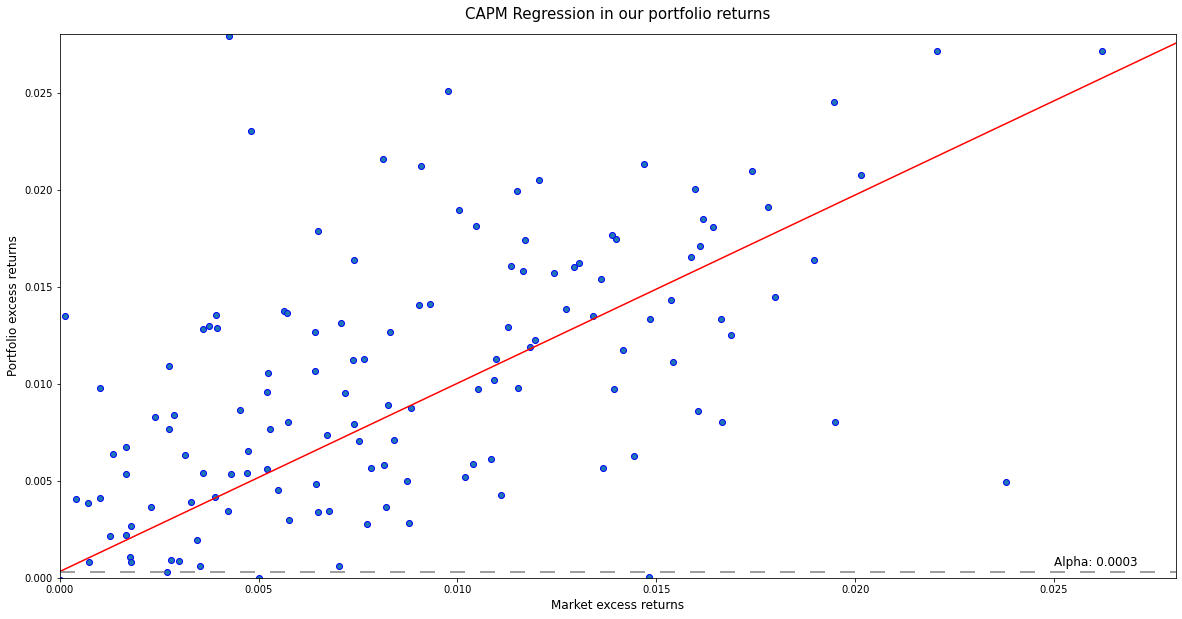

In [ ]:
#@title CAPM Pricing Model Regression
# Showing it graphically
fig, ax= plt.subplots(figsize=(20,10))
sm.graphics.abline_plot(model_results=results, color='r',ax=ax)
ax = fig.axes[0]
ax.scatter(benchmark, Y, edgecolors='blue')
ax.set_xlim(0, max(final_port))
ax.set_ylim(0, max(final_port))
ax.set_xlabel('Market excess returns', fontsize=12)
ax.set_ylabel('Portfolio excess returns', fontsize=12)
ax.axhline(y=results.params[0], c='Grey',dashes=(10,10))
plt.annotate('Alpha: '+str(np.round(results.params[0],4)),# The label for this point
                xy=(0.025, results.params[0]*2.5), # Position of the corresponding point
                ha='left',         # Horizontally aligned to the left
                va='center',
                fontsize=12)
plt.title('CAPM Regression in our portfolio returns', fontsize=15, pad=15);

**Yeah...we did not beat the market if we consider the CAPM risk adjusted returns** 😭


Other comments/limitations:

- Few, more or less random twitter accounts
- Sentiment score of the following tweet might me negative: "TSLA exploding"
- A lot of mentions are followed by emojis (i.e. 🚀)
- Assuming that we actually can buy at opening prices and sell at closing prices (would we really be able to?)
- 1 year only... should evaluate long-term
- Returns before taxes and fees (which we would charge)